In [1]:
import zipfile as zf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

###Generate main data

Изначально данные из файлов users.dat, movies.dat, ratings.dat были считаны в numpy.ndarray - users, movies, ratings соответственно. Далее каждая таблица была бинаризована:

* usr_bin: UserID | Age1 ... Age7 | Profession1 ... Profession21 | Male | Female
* mov_bin: MovieId | Genre1 ... Genre18 | epoch1 ... epoch8 (every ten years) | movie lenght (normalized to [0.1, 0.9])
* rat_bin: UserID | MovieID | Genre-based feature | User avegare rating | User info (from usr_bin) | Movie info (from mov_bin) | Movie avegare rating | Constant

В конечном итоге из всех данных будут использоватся матрицы rat_bin и ratings. Остальные были созданы для промежуточного использования для более легкой обработки данных.

В качестве дополнительных признаков были взяты:
* Год, отнесенный к десятилетию (для 1919-2000 годов были выделены 8 десятилетий, не 9 потому, что 1919 отнесен к тому же десятилетию, что и 1920)
* Длина названия фильма, нормированный к отрезку [0.1, 0.9]

#####Opening zip

In [3]:
z = zf.ZipFile('ml-1m.zip')

#####Getting data

Users' information
* UserID, Gender (1 is M), Age, Occupation

In [4]:
f = z.open('ml-1m/users.dat')
tmp = f.read()
tmp = tmp.decode()
users = np.array([np.array(t.split('::'))[: -1] for t in tmp.splitlines()]) # Zip-code not used
users[:, 1] = (users[:, 1] == 'M').astype(np.int)
users = users.astype(np.int)
f.close()

Movies' information
* MovieID, Title, Genres

In [5]:
f = z.open('ml-1m/movies.dat')
tmp = f.read()
tmp = tmp.decode('latin')
movies = np.array([np.array(t.split('::')) for t in tmp.splitlines()])
f.close()

Ratings' information
* UserID, MovieID, Rating, Timestamp

In [6]:
f = z.open('ml-1m/ratings.dat')
tmp = f.read()
tmp = tmp.decode()
ratings = np.array([np.array(t.split('::')) for t in tmp.splitlines()])
ratings = ratings.astype(np.float)
ratings[:, 2] /= 5
f.close()

In [7]:
z.close()

#####Binarization of data

<i>usr_bin</i>
* 1: UserId
* 7: Age
* 21: Profession
* 2: Gender (M, W)

In [8]:
ages = [1, 18, 25, 35, 45, 50, 56]
usr_bin = np.empty((users.shape[0], 1 + 7 + 21 + 2), dtype=np.int)

In [9]:
usr_bin[:, 0] = users[:, 0]
for i in range(len(ages)):
    usr_bin[:, i + 1] = users[:, 2] == ages[i]
for i in range(21):
    usr_bin[:, i + 1 + 7] = users[:, 3] == i
usr_bin[:, -2] = users[:, 1] == 1
usr_bin[:, -1] = users[:, 1] == 0

<i>mov_bin</i>
* 1: MovieId
* 18: Genres (genres.shape[0])
* 8: epoch (every ten years)
* 1: movie length (normalized to [0.1, 0.9]

In [10]:
genres = '''Action Adventure Animation Children's Comedy Crime Documentary Drama
Fantasy Film-Noir Horror Musical Mystery Romance Sci-Fi Thriller War Western'''.split()
genres = np.asarray(genres)

In [11]:
mov_bin = np.zeros((int(movies[-1, 0]), 1 + genres.shape[0] + 8 + 1), dtype=np.float)
j = 0
for i in range(mov_bin.shape[0]):
    mov_bin[i, 0] = i + 1
    try:
        mov = movies[movies[:, 0] == str(i + 1)]
        subgen = mov[:, 2][0].split('|')
        year = mov[:, 1][0][-5: -1]
        mov_len = len(mov[:, 1][0][: -6].split())
        for gen in subgen:
            mov_bin[i, 1: 19] += (gen == genres)
        
        epoch = (int(year) // 10) % 10 + (int(year) % 10 > 0)
        if epoch == 2:
            epoch = 3
        elif year == '2000':
            epoch = 10
        mov_bin[i, 19 + epoch - 3] = 1
        
        mov_bin[i, -1] = mov_len
    except:
        continue

In [12]:
mov_bin[:, -1] = (mov_bin[:, -1] - 1) / 14 * 0.8 + 0.1 # min is 1, max is 15

<i>rat_bin</i>
* 2: (UserID, MovieID)
* 30: User info (31 - 1)
* 27: Movie info (28 - 1)
* 1: Constant

Genre-based feature, user avg rating and movie avg rating will be added in estimator's fit

In [29]:
rat_bin = np.zeros((ratings.shape[0], 2 + usr_bin.shape[1] - 1 + mov_bin.shape[1] - 1 + 1))
rat_bin[:, :2] = ratings[:, :2]

In [14]:
import time

In [31]:
_time = time.clock()
for u in np.unique(usr_bin[:, 0]):
    indx = np.where(ratings[:, 0] == u)[0]
    rat = ratings[indx][:, 1]

    rat_bin[indx, 2: 32] = usr_bin[u - 1, 1:]
    rat_bin[indx, 32: 59] = mov_bin[rat.astype(np.int) - 1][:, 1:]
    rat_bin[indx, 59: 60] = 1
print('Time elapsed:', time.clock() - _time)

Time elapsed: 20.862625


In [32]:
maxMovieID = int(movies[-1][0])
maxUserID = users[-1, 0]

### Generate train-test

Генерация данных для обучения и контроля:

Для простоты работы, вместо самих данных, были сгенерированы индексы, соответствующие данным из обучения-контроля. Это сделано, т.к. данные делятся одинаково и для rat_bin и для ratings.

In [33]:
train_idx = []
test_idx = []
train_frac = 0.8

In [34]:
_time = time.clock()
i = 0
for u in np.unique(usr_bin[:, 0]):
    usrs = ratings[:, 0] == u
    indx = ratings[usrs, -1].argsort()
    indx += i
    thr = np.floor(indx.size * train_frac)
    train_idx += indx[: thr].tolist()
    test_idx += indx[thr: ].tolist()
    i += indx.size
print('Time elapsed:', time.clock() - _time)

Time elapsed: 36.409220000000005


In [41]:
del(users, movies,
    usr_bin, mov_bin,
    tmp, rat, z, f, mov_len, gen, year)

##1. Content-based подход

In [46]:
data = rat_bin
y = ratings[:, 2]

In [43]:
L = 0.2

Изначально, после Ridge-регрессии (без побдора оптимального параметра) ошибка равняется 0.028343817878777555. Время работы обучения 3.15 секунд.

#####CV for L

Для кросс-валидации (и для удобства) создадим класс для Content-based подхода

In [44]:
from sklearn import grid_search

In [45]:
from sklearn import base

In [113]:
class ContentBased(base.BaseEstimator, base.ClassifierMixin):
    def __init__(self, L=0.0001):
        self.L = L


    def fit(self, X, y):
        self.mov_avg_rat = np.zeros(maxMovieID)
        for i in range(self.mov_avg_rat.shape[0]):
            rats = y[np.where(X[:, 1] == i + 1)[0]]
            if len(rats):
                self.mov_avg_rat[i] = np.average(rats)
        
        data = np.zeros((X.shape[0], X.shape[1] + 1)) # -2 for IDs, +3 for features = +1
        data[:, :-3] = X[:, 2:]
        data[:, -3] = self.mov_avg_rat[X[:, 1].astype(np.int) - 1]
        
        self.usr_avg_rat = np.zeros(maxUserID)
        self.s = np.zeros((maxUserID, 27))
        
        for u in np.unique(X[:, 0]):
            indx = np.where(X[:, 0] == u)[0]
            self.usr_avg_rat[u - 1] = np.average(y[indx])
            
            s = np.sum(X[indx, 32: 59] * y[indx, np.newaxis], axis=0, dtype=np.float)
            div = X[indx, 32: 59].sum(axis=0)
            div[div == 0] = -1
            s /= div
            
            self.s[u - 1] = s
            
            data[indx, -2] = np.dot(X[indx, 32: 59], s) / X[indx, 32: 59].sum(axis=1)
            data[indx, -1] = self.usr_avg_rat[u - 1]
        
        self.time = time.clock()
#         inv = np.linalg.inv(np.dot(data.T, data) + self.L * np.eye(data.shape[1]))
        inv = np.linalg.solve(np.dot(data.T, data) + self.L * np.eye(data.shape[1]),
                              np.eye(data.shape[1]))
        self.w = np.dot(np.dot(inv, data.T), y)
        self.time = time.clock() - self.time


    def predict(self, X):
        data = np.zeros((X.shape[0], X.shape[1] + 1)) # -2 for IDs, +3 for features = +1
        data[:, :-3] = X[:, 2:]
        data[:, -3] = self.mov_avg_rat[X[:, 1].astype(np.int) - 1]
        
        for u in np.unique(X[:, 0]):
            indx = np.where(X[:, 0] == u)[0]
            
            data[indx, -2] = np.dot(X[indx, 32: 59], self.s[u - 1]) / X[indx, 32: 59].sum(axis=1)
            data[indx, -1] = self.usr_avg_rat[u - 1]

        return np.dot(data, self.w)


    def score(self, X, y, sample_weight=None):
        return -np.mean((self.predict(X) - y) ** 2)
    

    def myScore(self, true_y, pred_y):
        return np.mean((true_y - pred_y) ** 2)


In [129]:
cb = ContentBased(L=0.2)

In [130]:
cb.fit(data[train_idx], y[train_idx])

In [131]:
pred = cb.predict(data[test_idx])

In [132]:
cb.myScore(y[test_idx], pred)

0.045226320708928278

In [133]:
pred_tr = cb.predict(data[train_idx])

In [134]:
cb.myScore(y[train_idx], pred_tr)

0.028316630130354278

Ошибка сделана отрицательной специально для кросс-валидации, т.к. GridSearch максимизирует оценку. Также заметим, что ошибка оказалось такой же, как и в предыдущем пункте, что доказывает правильность написания класса.

In [115]:
gs = grid_search.GridSearchCV(cb, {'L': np.linspace(0, 0.5, 5)})

In [ ]:
_time = time.clock()
gs.fit(data[train_idx], y[train_idx])
print('Time elapsed:', time.clock() - _time)

<font size=1>P.S. Здесь кросс-валидация работала около 1003 секунд. Я нечаянно запустил после проверки и остановил</font>

In [117]:
gs.grid_scores_

[mean: -252478875910790719733760.00000, std: 357059498104465897029632.00000, params: {'L': 0.0},
 mean: -0.42036, std: 0.00399, params: {'L': 0.125},
 mean: -0.42038, std: 0.00399, params: {'L': 0.25},
 mean: -0.42039, std: 0.00399, params: {'L': 0.375},
 mean: -0.42041, std: 0.00399, params: {'L': 0.5}]

In [118]:
gs.best_params_

{'L': 0.125}

Как видно из ответов, ошибка не зависит от L до определнного знака. Также видно, что лучший параметр является близким к нулю, но не нулем. Проверим эту гипотезу:

In [121]:
gs = grid_search.GridSearchCV(cb, {'L': np.linspace(0, 0.0005, 5)})

In [122]:
_time = time.clock()
gs.fit(data[train_idx], y[train_idx])
print('Time elapsed:', time.clock() - _time)

Time elapsed: 1004.4788090000002


In [123]:
gs.grid_scores_

[mean: -252478875910790719733760.00000, std: 357059498104465897029632.00000, params: {'L': 0.0},
 mean: -0.42034, std: 0.00399, params: {'L': 0.000125},
 mean: -0.42034, std: 0.00399, params: {'L': 0.00025000000000000001},
 mean: -0.42034, std: 0.00399, params: {'L': 0.00037500000000000001},
 mean: -0.42034, std: 0.00399, params: {'L': 0.00050000000000000001}]

И в самом деле, ошибка минимиальна при L->0. В нашем случае возьмем L=0.0001

In [124]:
gs.best_params_

{'L': 0.000125}

Test ContentBased with best parametres

Проверяем правильность выбора параметра

In [136]:
cb = ContentBased()

In [137]:
_time = time.clock()
cb.fit(data[train_idx], y[train_idx])
print('Time elapsed:', time.clock() - _time)

Time elapsed: 97.43145100000038


In [138]:
_time = time.clock()
print(-cb.score(data[test_idx], y[test_idx]))
print('Time elapsed:', time.clock() - _time)

0.0452351302146
Time elapsed: 14.369012000000112


In [139]:
_time = time.clock()
print(-cb.score(data[train_idx], y[train_idx]))
print('Time elapsed:', time.clock() - _time)

0.0283166294937
Time elapsed: 57.8515239999997


Ошибка на обучении уменьшилась на $6 * 10^{-10}$, но на контроле ухудшилась. Это объяснятеся тем, что кросс-валидация проводилась для обучющей выборки.

<h3>Резюме по методу:</h3>
* Обучение на методе работает ~98 секунды
* Контроль на методе работает ~15 секунд
* Ошибка 0.0452351302146

##2. Neighborhood подход в коллаборативной фильтрации

Сначала выпишем формулы для user-oriented подхода

Имея матрицу user-item из оценок пользователей можно определить меру adjusted cosine similarity похожести пользователей u и v как векторов в пространстве товаров:

<center><font size=4>$sim(u, v) = \frac{\sum\nolimits_{i \in I} (r_{u,i} - \overline{r_i}) (r_{v,i} - \overline{r_i}) }{\sqrt{\sum\nolimits_{i \in I} (r_{u,i} - \overline{r_i})^2} \sqrt{\sum\nolimits_{i \in I} (r_{v,i} - \overline{r_i})^2} }$</font></center>

где I – множество товаров, которые были оценены пользователями u и v, $\overline{r_i}$ – средний рейтинг товара $i$.

Рейтинги для неизвестных фильмов считаются по следующей формуле:

<center><font size=4>$\hat{r}_{u,i} = \sum\limits_{v: \, r_{v,i} \neq 0} sim(u, v) \, r_{v,i} \big/ \sum\limits_{v: \, r_{v,i} \neq 0 } sim(u, v)$</font></center>

In [350]:
class NeighborhoodBased():
    def __init__(self):
        self.isPredicted = False


    def fit(self, X):
        """
        X: (u, i, r) matrix
        """
        usr_itm = np.zeros((maxUserID, maxMovieID))
        usr_avg = np.zeros((maxUserID, 1))
        
        for u in np.unique(X[:, 0]):
            indx = X[:, 0] == u
            rat = X[indx][:, 1:]
            usr_avg_rat = np.average(rat[:, 1])

            usr_itm[u - 1, rat[:, 0].astype(np.int) - 1] = rat[:, 1]
            usr_avg[u - 1] = usr_avg_rat
        
        self.ui = usr_itm
        
        tmp = usr_itm - usr_avg
        tmp[tmp < -usr_avg + 0.0001] = 0
        
        del(usr_itm, usr_avg)
        
        div = np.sqrt(np.sum(tmp ** 2, axis=0))
        div[div == 0] = 1
        div_sim = tmp / div
        
        del(tmp)
        
        self.sim = np.dot(div_sim.T, div_sim)
        self.sim[self.sim < 0] = 0
        
        self.argmax = np.argsort(self.sim, axis=0)

        
    def predict(self, X, N=None):
        """
        X: (u, i) matrix
        """
        sim = np.copy(self.sim)
        if N is not None:
            for i in range(self.argmax.shape[1]):
                sim[self.argmax[:-N, i], i] = 0

        _time = time.clock()
        ans = []
        for u in np.unique(X[:, 0]):
            ind = np.where(self.ui[u - 1] != 0)[0]
            movies = (X[X[:, 0] == u, 1] - 1).astype(np.int)
            div = np.sum(sim[ind][:, movies], axis=0)
            div[div == 0] = 1
            ans += (np.dot(self.ui[u - 1][ind], sim[ind][:, movies]) / div).tolist()

        self.predict_time = time.clock() - _time
        return np.array(ans)


    def score(self, y_true, y_predict):
        return np.mean((y_true - y_predict) ** 2)


In [381]:
nb = NeighborhoodBased()

In [382]:
_time = time.clock()
nb.fit(ratings[train_idx, :-1])
time_nb_training = time.clock() - _time

Тестируем время работы и качество метода в зависимости от N: первых самых похожих фильмов j по мере sim(i, j)

In [383]:
score_nb_tr = []
score_nb_te = []
time_nb_tr_pre = []
time_nb_te_pre = []

for N in np.arange(50, 2000, 100):
    pred = nb.predict(ratings[test_idx, :-2], N)
    time_nb_te_pre.append(nb.predict_time)
    score_nb_te.append(nb.score(ratings[test_idx, -2], pred))
    
    pred = nb.predict(ratings[train_idx, :-2], N)
    time_nb_tr_pre.append(nb.predict_time)
    score_nb_tr.append(nb.score(ratings[train_idx, -2], pred))

In [429]:
plt.rcParams['figure.figsize'] = 10, 5

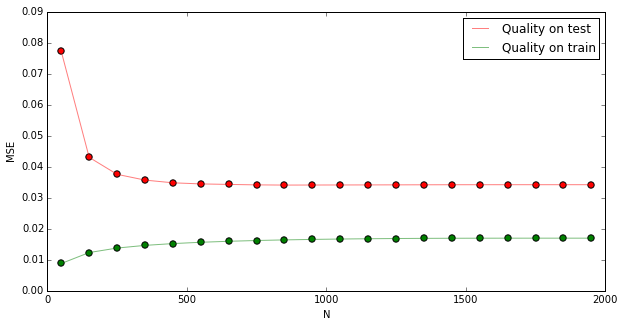

In [432]:
plt.plot(np.arange(50, 2000, 100), score_nb_te, alpha=0.5, c='red', label='Quality on test')
plt.scatter(np.arange(50, 2000, 100), score_nb_te, c='red', s=40)

plt.plot(np.arange(50, 2000, 100), score_nb_tr, alpha=0.5, c='g', label='Quality on train')
plt.scatter(np.arange(50, 2000, 100), score_nb_tr, c='g', s=40)

plt.xlabel('N')
plt.ylabel('MSE')
plt.xlim(0, 2000)
plt.legend(loc='best')

Из графика выше видно, что ошибка на контроле до ~700 падает и начиная с ~700 перестает изменяться. В случае качества на обучении ошибка увеличивается и опять же начиная с ~700 перестает меняться. Т.е. при N < 700 происходит переобучение, следовательно надо брать N > 700

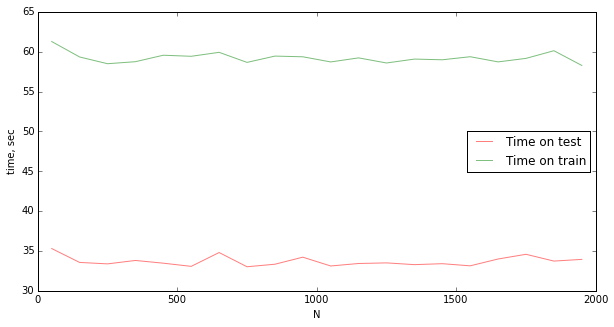

In [434]:
plt.plot(np.arange(50, 2000, 100), time_nb_te_pre, alpha=0.5, c='red', label='Time on test')

plt.plot(np.arange(50, 2000, 100), time_nb_tr_pre, alpha=0.5, c='g', label='Time on train')

plt.xlabel('N')
plt.ylabel('time, sec')
plt.xlim(0, 2000)
plt.legend(loc='best')

Время работы метода не зависит от N

In [403]:
time_nb_training

35.658054000003176

In [452]:
# nb.fit(ratings[train_idx, :-1])
pred = nb.predict(ratings[test_idx, :-2])
print(nb.predict_time)
print(nb.score(ratings[test_idx, -2], pred))

33.604944999999134
0.0342283108932


<h3>Резюме по методу:</h3>
* Обучение на методе работает ~35 секунд
* Контроль на матоде работает ~35 секунд
* Ошибка 0.0342283108932

##3. Latent factor подход в коллаборативной фильтрации

Выпишем формулы для перенастройки $q_i$ при фиксированной матрице P:

\begin{align}
A_i &= P[i]^T P[i] \\
d_u &= P[i]^T r_i \\
q_i &= (\lambda_q n_i I + A_i)^{-1} d_u \\
\end{align}

где $P[i]$ подматрица матрицы $P$ только для пользователей, оценивших фильм $i$, $n_i$ - количество пользователей, оценивших фильм $i$.

In [407]:
class LatendFactorBased(base.BaseEstimator, base.ClassifierMixin):
    def __init__(self, L_p=0.7, L_q=0.0005, N=10, K=30):
        self.L_p = L_p
        self.L_q = L_q
        self.N = N
        self.K = K

    def fit(self, X, y):
        """
        X: (u, i)
        y: (r)
        """
        self.Q = 0.1 * np.random.rand(maxMovieID, self.K)
        self.P = 0.1 * np.random.rand(maxUserID, self.K)
        X = X.astype(np.int)

        indx_u = []
        indx_i = []
        for u in range(maxUserID):
            indx_u.append(np.where(X[:, 0] == u + 1)[0])

        for i in range(maxMovieID):
            indx_i.append(np.where(X[:, 1] == i + 1)[0])

        for n in range(self.N):
            for u in np.unique(X[:, 0]):
                mov = X[indx_u[u - 1], 1]
                A = np.dot(self.Q[mov - 1].T, self.Q[mov - 1])
                d = np.dot(self.Q[mov - 1].T, y[indx_u[u - 1]])
                try:
#                     self.P[u - 1] = np.dot(np.linalg.inv(self.L_p * indx_u[u - 1].size * np.eye(self.K) + A), d)
                    self.P[u - 1] = np.dot(np.linalg.solve(self.L_p * indx_u[u - 1].size * np.eye(self.K) + A,
                                                           np.eye(self.K)),
                                           d)
                except:
                    pass
                
            for i in np.unique(X[:, 1]):
                usr = X[indx_i[i - 1], 0]
                A = np.dot(self.P[usr - 1].T, self.P[usr - 1])
                d = np.dot(self.P[usr - 1].T, y[indx_i[i - 1]])
                try:
#                     self.Q[i - 1] = np.dot(np.linalg.inv(self.L_q * indx_i[i - 1].size * np.eye(self.K) + A), d)
                    self.Q[i - 1] = np.dot(np.linalg.solve(self.L_q * indx_i[i - 1].size * np.eye(self.K) + A,
                                                           np.eye(self.K)),
                                           d)
                except:
                    pass


    def predict(self, X):
        ans = []
        X = X.astype(np.int)
        for u in np.unique(X[:, 0]):
            indx = X[:, 0] == u
            mov = X[indx, 1]
            ans += np.dot(self.P[u - 1], self.Q[mov - 1].T).tolist()

        return ans

    def score(self, X, y, sample_weight=None):
        return -np.mean((self.predict(X) - y) ** 2)


In [228]:
lf = LatendFactorBased()

In [229]:
_time = time.clock()
lf.fit(ratings[train_idx, :-2], ratings[train_idx, -2])
print(time.clock() - _time)

36.01040399999965


In [230]:
pred = lf.predict(ratings[test_idx, :-2])

In [231]:
np.mean((pred - ratings[test_idx, -2]) ** 2)

0.030379431906997718

Изначально (до подбора параметров) ошибка на методе равняется 0.030379431906997718. Время работы ~36 секунд

#####CV for L_p, L_q, K, N

#####Search for L_p

In [254]:
lf = LatendFactorBased()

In [256]:
params = [
    {'L_p': np.linspace(0.1, 1, 10)},
]
gs = grid_search.GridSearchCV(lf, params)

In [257]:
gs.fit(ratings[train_idx, :-2], ratings[train_idx, -2])

GridSearchCV(cv=None, error_score='raise',
       estimator=LatendFactorBased(K=10, L_p=0.2, L_q=0.001, N=20),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'L_p': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [258]:
gs.grid_scores_

[mean: -0.24248, std: 0.00343, params: {'L_p': 0.10000000000000001},
 mean: -0.14252, std: 0.00436, params: {'L_p': 0.20000000000000001},
 mean: -0.09992, std: 0.00177, params: {'L_p': 0.30000000000000004},
 mean: -0.07774, std: 0.00097, params: {'L_p': 0.40000000000000002},
 mean: -0.06815, std: 0.00080, params: {'L_p': 0.5},
 mean: -0.06088, std: 0.00063, params: {'L_p': 0.59999999999999998},
 mean: -0.05688, std: 0.00065, params: {'L_p': 0.70000000000000007},
 mean: -0.05738, std: 0.00078, params: {'L_p': 0.80000000000000004},
 mean: -0.05769, std: 0.00084, params: {'L_p': 0.90000000000000002},
 mean: -0.05954, std: 0.00155, params: {'L_p': 1.0}]

In [259]:
gs.best_params_

{'L_p': 0.70000000000000007}

#####Search for L_q

In [275]:
lf = LatendFactorBased()

In [276]:
params = [
    {'L_q': np.linspace(0.0005, 0.0015, 10)},
]
gs = grid_search.GridSearchCV(lf, params)

In [277]:
gs.fit(ratings[train_idx, :-2], ratings[train_idx, -2])

GridSearchCV(cv=None, error_score='raise',
       estimator=LatendFactorBased(K=10, L_p=0.2, L_q=0.001, N=20),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'L_q': array([ 0.0005 ,  0.00061,  0.00072,  0.00083,  0.00094,  0.00106,
        0.00117,  0.00128,  0.00139,  0.0015 ])}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [278]:
gs.grid_scores_

[mean: -0.13509, std: 0.00547, params: {'L_q': 0.00050000000000000001},
 mean: -0.13690, std: 0.00181, params: {'L_q': 0.0006111111111111111},
 mean: -0.13849, std: 0.00103, params: {'L_q': 0.00072222222222222219},
 mean: -0.14039, std: 0.00344, params: {'L_q': 0.00083333333333333339},
 mean: -0.14200, std: 0.00080, params: {'L_q': 0.00094444444444444448},
 mean: -0.14670, std: 0.00136, params: {'L_q': 0.0010555555555555557},
 mean: -0.14848, std: 0.00192, params: {'L_q': 0.0011666666666666668},
 mean: -0.14768, std: 0.00090, params: {'L_q': 0.0012777777777777779},
 mean: -0.15297, std: 0.00134, params: {'L_q': 0.0013888888888888889},
 mean: -0.15286, std: 0.00272, params: {'L_q': 0.0015}]

In [279]:
gs.best_params_

{'L_q': 0.00050000000000000001}

#####Search for N

In [391]:
score_lf_N = []
for N in [5, 10, 15, 20, 25, 30, 35, 40]:
    lf = LatendFactorBased(N=N)
    lf.fit(ratings[train_idx, :-2], ratings[train_idx, -2])
    score_lf_N.append(-lf.score(ratings[test_idx, :-2], ratings[test_idx, -2]))

In [392]:
score_lf_N

[0.030589071791976022,
 0.030304404839377509,
 0.030314410471495374,
 0.030321270201944906,
 0.030334266098952452,
 0.030328990089645222,
 0.030338534512974216,
 0.030357724817903768]

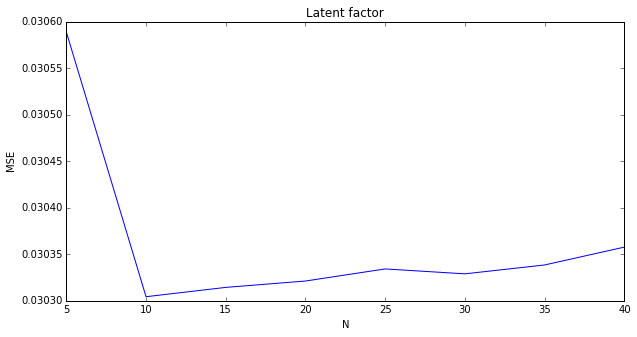

In [443]:
plt.plot([5, 10, 15, 20, 25, 30, 35, 40], score_lf_N)

plt.xlabel('N')
plt.ylabel('MSE')
plt.title('Latent factor')

На графике выше изображена зависимость качества от количества итераций в методе. Можно заметить, что при N = 10 ошибка достигает минимума, а дальше ошибка растет. Следовательно для метода можно выбрать N = 10

#####Testing speed and quality depend on K 

In [410]:
score_lf_tr = []
score_lf_te = []
time_lf_tr_pre = []
time_lf_te_pre = []
time_lf_training = []
for K in range(10, 60, 10):
    lf = LatendFactorBased(K=K)
    
    _time = time.clock()
    lf.fit(ratings[train_idx, :-2], ratings[train_idx, -2])
    time_lf_training.append(time.clock() - _time)
    
    _time = time.clock()
    score_lf_tr.append(-lf.score(ratings[train_idx, :-2], ratings[train_idx, -2]))
    time_lf_tr_pre.append(time.clock() - _time)
    
    _time = time.clock()
    score_lf_te.append(-lf.score(ratings[test_idx, :-2], ratings[test_idx, -2]))
    time_lf_te_pre.append(time.clock() - _time)

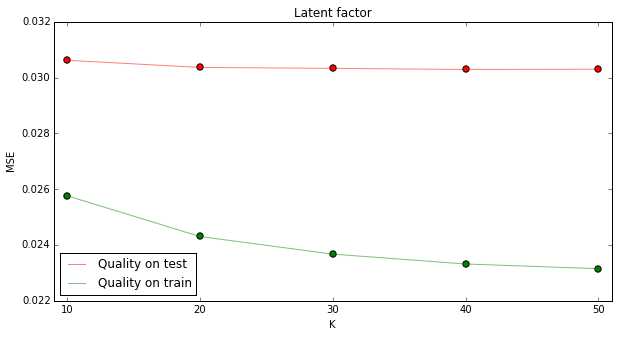

In [440]:
plt.plot(range(10, 60, 10), score_lf_te, alpha=0.5, c='red', label='Quality on test')
plt.scatter(range(10, 60, 10), score_lf_te, c='red', s=40)

plt.plot(range(10, 60, 10), score_lf_tr, alpha=0.5, c='g', label='Quality on train')
plt.scatter(range(10, 60, 10), score_lf_tr, c='g', s=40)

plt.xlabel('K')
plt.ylabel('MSE')
plt.xlim(9, 51)
plt.title('Latent factor')
plt.legend(loc='best')

На графике выше изображена зависимоть качества от размерности K пространства латентных признаков. Увеличение пространства латентных признаков не ведет к переобучению, но улучшает качество. Чем больше K, тем лучше качество. Но в случае контрольной выборки можно заметить, что после K=40 качество практический не изменяется. Следовательно для метода мы можем взять K=40

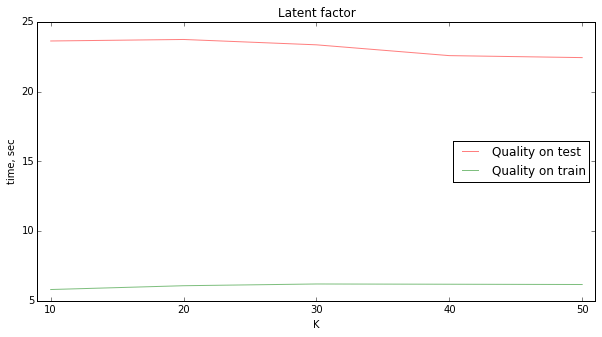

In [453]:
plt.plot(range(10, 60, 10), time_lf_tr_pre, alpha=0.5, c='red', label='Quality on test')

plt.plot(range(10, 60, 10), time_lf_te_pre, alpha=0.5, c='g', label='Quality on train')

plt.xlabel('K')
plt.ylabel('time, sec')
plt.xlim(9, 51)
plt.title('Latent factor')
plt.legend(loc='best')

Время работы метода практический не зависит от размерности пространства латентных признаков

После кросс-валидаций и подбора N и K, оптимальными параметрами являются: N = 10, K = 40, L_p = 0.7, L_q = 0.0005. Далее проверим правильность подбора параметров: ошибка уменьшилась на $8.4 * 10^{-5}$. Но время работы увеличилось до 58 секунд (на 12 секунд дольше)

Testing LatentFactorBased with best parametres

In [414]:
lf = LatendFactorBased(K=40)

In [415]:
lf.get_params()

{'K': 40, 'L_p': 0.7, 'L_q': 0.0005, 'N': 10}

In [416]:
_time = time.clock()
lf.fit(ratings[train_idx, :-2], ratings[train_idx, -2])
print(time.clock() - _time)

57.911190999999235


In [417]:
_time = time.clock()
pred = lf.predict(ratings[test_idx, :-2])
print(time.clock() - _time)

6.380503000000317


In [418]:
np.mean((pred - ratings[test_idx, -2]) ** 2)

0.030295898982622135

<h3>Резюме по методу:</h3>
* Обучение на методе работает ~58 секунд
* Контроль на матоде работает ~6.5 секунд
* Ошибка 0.030295898982622135

<h1>Выводы</h1>
Приведем сравнительную таблицу методов:

<table>
  <tr>
    <td></td>
    <td>Content-based</td>
    <td>Neighborhood</td>
    <td>Latent factor</td>
  </tr>
  <tr>
    <td>Время обучения, сек</td>
    <td>98</td>
    <td>35</td> 
    <td>58</td>
  </tr>
  <tr>
    <td>Время контроля, сек</td>
    <td>15</td>
    <td>35</td> 
    <td>6.5</td>
  </tr>
  <tr>
    <td>Ошибка</td>
    <td>0.0452351302146</td>
    <td>0.0342283108932</td> 
    <td>0.0302958989826</td>
  </tr>
</table>

Из таблицы можно увидеть, что лучший по качеству метод - laten factor. Но по времени обучения не самый быстрый. Но это не критично, т.к. обучение проходит не так часто, как получение ответа алгоритма. А по времени контроля этот метод самый быстрый, что является еще одним критерием выбора метода.

Вторым идет метод Neighborhood. Время обучения и контроля одинаковое и не самое быстрое, но качество хорошее

И наконец, последним идет метод Content-based. Время обучения долгое, качество худшее, как и сказано в тексте задания